<a href="https://colab.research.google.com/github/alirezasakhaei/RL_Course2023_Homeworks/blob/main/HWO4/RL_HW4_SAC_98101714.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Actor Critic Agent(115 Points)

> Name: Alireza Sakhaeirad

> SID: 98101714



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
import warnings
warnings.filterwarnings("ignore")


## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [ ]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        ##########################################################
        hidden_layer_units_1 = 16
        hidden_layer_units_2 = 64

        self.hidden_layer_1 = nn.Linear(input_dimension, hidden_layer_units_1)
        self.hidden_layer_2 = nn.Linear(hidden_layer_units_1, hidden_layer_units_2)
        self.output_layer = nn.Linear(hidden_layer_units_2, output_dimension)
        self.output_layer_activation = output_activation
        self.relu = F.relu
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        # Use relu and the output activation functions to calculate the output
        ##########################################################

        ####
        x = self.hidden_layer_1(inpt)
        x = self.relu(x)
        ####
        x = self.hidden_layer_2(x)
        x = self.relu(x)
        ####
        x = self.output_layer(x)
        output = self.output_layer_activation(x)
        return output
        ##########################################################

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [ ]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.


❓ Write down the actor cost function.

❓ Write down the critic cost function.


❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).

❓ What is the difference between training samples in offline and online settings?


❓ How does adding CQL on top of SAC change the objective function?


**I answered the questions in the pdf file, along with the theory questions**

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

<p style="color:yellow;">This implemenation is based on the paper "SOFT ACTOR-CRITIC FOR DISCRETE ACTION SETTINGS (Christodoulou P,  2019)" where slight changes to use SAC in discrete setting was introduced.</p>

In [ ]:
ALPHA_INITIAL = 1.
REPLAY_BUFFER_BATCH_SIZE = 100
DISCOUNT_RATE = 0.99
LEARNING_RATE = 10 ** -4
SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
TRADEOFF_FACTOR = 5 # trade-off factor in the CQL
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class SACAgent:

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):

        #assert use_cql and not offline, 'Please activate the offline flag for CQL.'
        #assert offline and replay_buffer is None, 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.LEARNING_RATE = 10 ** -4
        self.DISCOUNT_RATE = 0.99
        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################

        # Defining Networks
        self.critic_local = Network(self.state_dim, self.action_dim)
        self.critic_local2 = Network(self.state_dim, self.action_dim)
        self.critic_target = Network(self.state_dim, self.action_dim)
        self.critic_target2 = Network(self.state_dim, self.action_dim)

        # Defining Optimizers
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)

        ##########################################################

        self.soft_update_target_networks(tau=1.)
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=LEARNING_RATE)

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, torch.nn.Softmax(dim=1))
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)


        # Sending all networks to GPU
        def dev(net):
            return net.to(self.DEVICE)
        self.networks = [self.critic_local,
                         self.critic_local2,
                         self.critic_target,
                         self.critic_target2,
                         self.actor_local]
        for net in self.networks:
            net = dev(net)

        self.optimizers = [self.critic_optimiser,
                           self.critic_optimiser2,
                           self.actor_optimiser,
                           self.alpha_optimiser]
        ##########################################################


    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    # Added method
    def calc_soft_v(self, Q_hat_min, next_states_tensor):
        action_prob, log_action_prob = self.get_action_info(next_states_tensor)
        temp = Q_hat_min - self.alpha * log_action_prob
        temp = action_prob * temp
        soft_v = torch.sum(temp, dim=1)
        return soft_v

    # Added method
    def get_Q_min(self, states_tensor, is_local = True):
        with torch.no_grad():
            if is_local:
                Q_local_1 = self.critic_local(states_tensor)
                Q_local_2 = self.critic_local2(states_tensor)
                Q_min = torch.min(Q_local_1, Q_local_2)
            else:
                Q_local_1 = self.critic_target(states_tensor)
                Q_local_2 = self.critic_target2(states_tensor)
                Q_min = torch.min(Q_local_1, Q_local_2)
        return Q_min

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        loss_fn = nn.MSELoss()

        # Pass the states throught critic network to calculate Q_theta
        Q_theta_local_1 = self.critic_local(states_tensor)
        len_output = Q_theta_local_1.size(0)
        Q_theta_local_1 = Q_theta_local_1[torch.arange(len_output), actions_tensor]

        Q_theta_local_2 = self.critic_local2(states_tensor)
        len_output = Q_theta_local_1.size(0)
        Q_theta_local_2 = Q_theta_local_2[torch.arange(len_output), actions_tensor]

        # Compute the target values
        with torch.no_grad():


            # Getting Q values
            Q_hat_min = self.get_Q_min(next_states_tensor, is_local=False)

            # Soft-maxing Q values to get V
            soft_V = self.calc_soft_v(Q_hat_min, next_states_tensor)

            # Target values
            Q_target = rewards_tensor + (self.DISCOUNT_RATE * (torch.logical_not(done_tensor))*soft_V)

        critic_loss = loss_fn(Q_theta_local_1, Q_target)
        critic2_loss = loss_fn(Q_theta_local_2, Q_target)

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################

        # Getting action probabilities
        action_prob, log_action_prob = self.get_action_info(states_tensor)

        # To calculate actor loss, first we query the critic networks
        min_Q_critic = self.get_Q_min(states_tensor, is_local=True)

        # Now we calculate the loss
        actor_loss = torch.mean(torch.sum(action_prob*(self.alpha*log_action_prob-min_Q_critic)))

        return actor_loss, log_action_prob
        ##########################################################


    def train_on_transition(self, transition):
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        # self.actor_optimiser.zero_grad()
        # self.critic_optimiser.zero_grad()
        # self.critic_optimiser2.zero_grad()
        # self.alpha_optimiser.zero_grad()
        for opt in self.optimizers:
            opt.zero_grad()

        # Only for online mode
        if not self.offline:
            self.replay_buffer.add_transition(transition)
        ##########################################################

        if self.replay_buffer.get_size() >= REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0])).to(DEVICE)
            actions_tensor = torch.tensor(np.array(minibatch_separated[1])).to(DEVICE)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float().to(DEVICE)
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3])).to(DEVICE)
            done_tensor = torch.tensor(np.array(minibatch_separated[4])).to(DEVICE)

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################

            def net_update(loss, opt):
                loss.backward()
                opt.step()

            # Critic Update
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor)
            net_update(critic_loss, self.critic_optimiser)
            net_update(critic2_loss, self.critic_optimiser2)

            # Actor Update
            actor_loss, log_action_prob = self.actor_loss(states_tensor)
            net_update(actor_loss, self.actor_optimiser)

            # Alpha Update
            alpha_loss = self.temperature_loss(log_action_prob)
            net_update(alpha_loss, self.alpha_optimiser)
            ##########################################################

            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().cpu().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [ ]:
def plot(REWARDS):
    mean_vals = np.mean(REWARDS, axis=0)
    std_vals = np.std(REWARDS, axis=0)
    xrange = np.arange(len(REWARDS[0]))*4
    plt.errorbar(xrange, mean_vals, yerr=std_vals, fmt='o', capsize=3, c='black')
    plt.grid(True)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()


In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################
REWARDS = []
RUNS = 5
for run in range(RUNS):
    print('-'*30)
    print(f'RUN: {run}')

    # Agent and Buffer Initialization
    agent = SACAgent(env)
    replay_buffer = ReplayBuffer(env)
    run_rewards = []

    for eps in tqdm(range(EPISODES_PER_RUN)):
        state = env.reset()
        episode_reward = 0
        evaluation_mode = False
        if eps % TRAINING_EVALUATION_RATIO == 0:
            evaluation_mode = True
        done = False
        for step in range(STEPS_PER_EPISODE):
            if done:
                break
            action = agent.get_next_action(state, evaluation_mode)
            next_state, reward, done, info = env.step(action)
            trans = (state, action, reward, next_state, done)
            replay_buffer.add_transition(trans)

            if evaluation_mode:
                episode_reward += reward
            else:
                agent.train_on_transition(trans)

            state = next_state

        if evaluation_mode:
            run_rewards.append(episode_reward)

    REWARDS.append(run_rewards)

env.close()

------------------------------
RUN: 0


100%|██████████| 500/500 [03:57<00:00,  2.11it/s]


------------------------------
RUN: 1


100%|██████████| 500/500 [00:41<00:00, 11.95it/s]


------------------------------
RUN: 2


100%|██████████| 500/500 [03:08<00:00,  2.66it/s]


------------------------------
RUN: 3


100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


------------------------------
RUN: 4


100%|██████████| 500/500 [01:02<00:00,  7.98it/s]


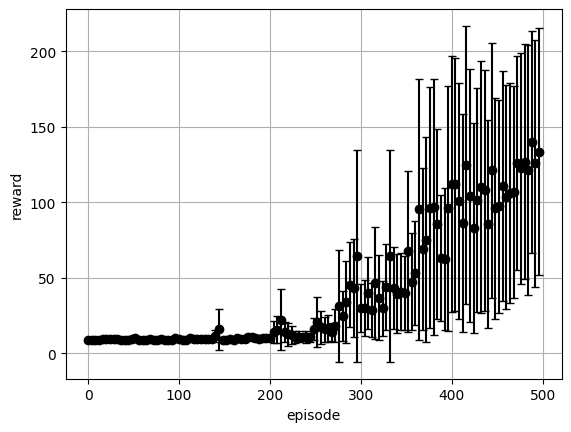

In [ ]:
plot(REWARDS)

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

In [ ]:
RUNS = 4
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################
REWARDS_offline = []
for run in range(RUNS):
    print('-'*30)
    print(f'RUN: {run}')

    # Agent Initialization
    # Buffer from previous section
    agent = SACAgent(env, replay_buffer=replay_buffer, offline = True)
    run_rewards = []

    for eps in tqdm(range(EPISODES_PER_RUN)):
        state = env.reset()
        episode_reward = 0
        evaluation_mode = False
        if eps % TRAINING_EVALUATION_RATIO == 0:
            evaluation_mode = True
        done = False
        for step in range(STEPS_PER_EPISODE):
            if done:
                break
            action = agent.get_next_action(state, evaluation_mode)
            next_state, reward, done, info = env.step(action)

            if evaluation_mode:
                episode_reward += reward
            else:
                agent.train_networks()

            state = next_state

        if evaluation_mode:
            run_rewards.append(episode_reward)

    REWARDS_offline.append(run_rewards)

env.close()

------------------------------
RUN: 0


100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


------------------------------
RUN: 1


100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


------------------------------
RUN: 2


100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


------------------------------
RUN: 3


100%|██████████| 200/200 [00:21<00:00,  9.52it/s]


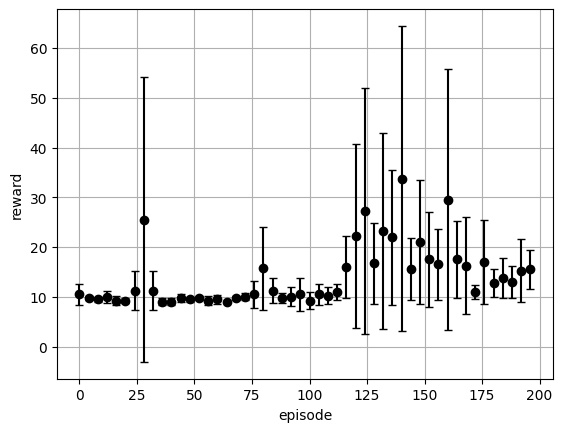

In [ ]:
plot(REWARDS_offline)

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?


❓ Which one is better: offline SAC or conservative SAC?


❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?


**I answered the questions in the pdf file, along with the theory questions**